# Import statements

Pip installations

In [ ]:
!pip install ultralytics

Import statements

In [2]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adadelta
import cv2
import matplotlib.pyplot as plt
# from ultralytics import YOLO

# Directory paths

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
dataset_dir = '/content/drive/MyDrive/Research Files/Other files/Development/Dataset/Dataset'
segmentation_model = '/content/drive/MyDrive/Research Files/Other files/Development/YOLOv8 Trained Model/best.pt'

# Global variables

In [6]:
# tf.data.Dataset
MAX_SEQUENCE_LENGTH = 45
BATCH_SIZE = 4
SHUFFLE_BUFFER_SIZE = 100
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

IMAGE_WIDTH = 291
IMAGE_HEIGHT = 218
IMAGE_CHANNELS = 3

LOSS_FUNCTION = "mean_squared_error"

LEARNING_RATE = 1.0
OPTIMIZER = Adadelta(learning_rate=LEARNING_RATE)

EPOCHS = 50

AUGMENT_PROBABILITY = 0.5

# Functions

In [9]:
def get_sequences(sequence_dir):
    sequence_paths = sorted(
        [os.path.join(sequence_dir, d) for d in os.listdir(sequence_dir) if os.path.isdir(os.path.join(sequence_dir, d))]
    )
    sequences = []
    for seq_path in sequence_paths:
        frame_paths = sorted(glob.glob(os.path.join(seq_path, '*.*')))  # Adjust the pattern if needed
        sequences.append(frame_paths)
    return sequences

In [21]:
def create_tf_dataset(sequences):
    dataset = tf.data.Dataset.from_generator(
        lambda: sequence_generator(sequences),
        output_types=tf.string,
        output_shapes=(None,)
    )
    return dataset

In [20]:
def sequence_generator(sequences):
    for sequence in sequences:
        yield sequence

In [24]:
def visualize_sequences(sequences, set_name):
    """
    Visualizes the first 5 frames from the first 2 sequences in the provided sequences list.

    Args:
        sequences (list): List of sequences, where each sequence is a list of frame paths.
        set_name (str): Name of the dataset (e.g., 'Training', 'Validation', 'Test') for titles.
    """
    num_sequences = min(2, len(sequences))  # We want to display up to 2 sequences

    for seq_idx in range(num_sequences):
        sequence = sequences[seq_idx]
        num_frames = min(5, len(sequence))  # Ensure we don't exceed the number of frames in the sequence
        frames = sequence[:num_frames]

        plt.figure(figsize=(15, 5))
        for idx, frame_path in enumerate(frames):
            # Read the image
            img = cv2.imread(frame_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Resize image for display purposes (e.g., to width=400 pixels)
            scale_factor = 400 / img.shape[1]
            new_width = int(img.shape[1] * scale_factor)
            new_height = int(img.shape[0] * scale_factor)
            display_img = cv2.resize(img, (new_width, new_height))

            # Plot the image
            plt.subplot(1, num_frames, idx + 1)
            plt.imshow(display_img)
            plt.title(f'Seq {seq_idx + 1}, Frame {idx + 1}')
            plt.axis('off')

        plt.suptitle(f'{set_name} Set - Sequence {seq_idx + 1}')
        plt.show()

In [ ]:
def preprocess_image(image_path):
    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # ------------------------------

    # Apply segmentation model
    results = segmentation_model.predict(source=img, save=False, verbose=False)

    # Get the segmentation mask
    masks = results[0].masks
    if masks is not None and len(masks.data) > 0:
        # Assuming the first mask is the plant
        mask = masks.data[0].cpu().numpy()  # Shape: (H, W)
        mask = (mask * 255).astype(np.uint8)
    else:
        # If no mask is found, use an empty mask
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    # Apply the mask to the image
    segmented_img = cv2.bitwise_and(img, img, mask=mask)

    # ------------------------------

    # Resize the image
    img_resized = cv2.resize(segmented_img, (IMAGE_WIDTH, IMAGE_HEIGHT))

    # ------------------------------

    # Normalize the image to [0,1]
    img_normalized = img_resized / 255.0

    return img_normalized.astype(np.float32)

In [ ]:
def preprocess_sequence(frame_paths, max_length):
    frames = []
    for frame_path in frame_paths:
        img = preprocess_image(frame_path)
        frames.append(img)
    frames = np.array(frames)

    # Pad or truncate the sequence to 'max_length'
    sequence_length = frames.shape[0]
    if sequence_length < max_length:
        # Pad with zeros at the beginning
        pad_length = max_length - sequence_length
        padding = np.zeros((pad_length, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.float32)
        frames = np.concatenate([padding, frames], axis=0)
    else:
        # Truncate the sequence
        frames = frames[-max_length:]
    return frames

In [ ]:
def process_sequence_tf(frame_paths):
    frames = tf.py_function(
        func=preprocess_sequence,
        inp=[frame_paths, MAX_SEQUENCE_LENGTH],
        Tout=tf.float32
    )
    frames.set_shape([MAX_SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    return frames

In [ ]:
def create_input_target(frames):
    inputs = frames[:-1]   # Exclude the last frame
    targets = frames[1:]   # Exclude the first frame
    return inputs, targets

In [ ]:
def augment_sequence(frames):
    """
    Applies random augmentations to a sequence of frames.

    Args:
        frames: Tensor of shape (sequence_length, height, width, channels)

    Returns:
        Augmented frames of the same shape.
    """
    def _augment(frames_np):
        # Decide whether to apply augmentation
        if np.random.rand() < AUGMENT_PROBABILITY:
            # Define augmentation parameters
            # Example: Random flip and rotation
            flip_code = np.random.choice([None, 0, 1, -1])  # None: no flip, 0: vertical, 1: horizontal, -1: both
            angle = np.random.uniform(-15, 15)  # Rotate between -15 to 15 degrees

            # Define the rotation matrix
            if angle != 0:
                center = (IMAGE_WIDTH / 2, IMAGE_HEIGHT / 2)
                rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

            augmented_frames = []
            for frame in frames_np:

                # Apply flip if selected
                if flip_code is not None:
                    frame = cv2.flip(frame, flip_code)

                # Apply rotation if angle is not zero
                if angle != 0:
                    frame = cv2.warpAffine(frame, rotation_matrix, (IMAGE_WIDTH, IMAGE_HEIGHT), borderMode=cv2.BORDER_REFLECT)


                augmented_frames.append(frame)

            augmented_frames = np.array(augmented_frames)
            return augmented_frames.astype(np.float32)
        else:
            # No augmentation applied
            return frames_np

    # Use tf.py_function to apply the augmentation
    augmented_frames = tf.py_function(func=_augment, inp=[frames], Tout=tf.float32)

    # Set the shape
    augmented_frames.set_shape([MAX_SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    return augmented_frames

# Import dataset

## Load dataset

Load dataset

In [14]:
train_sequences_dir = os.path.join(dataset_dir, 'train_set')
val_sequences_dir = os.path.join(dataset_dir, 'val_set')
test_sequences_dir = os.path.join(dataset_dir, 'test_set')

In [16]:
train_sequences = get_sequences(train_sequences_dir)
val_sequences = get_sequences(val_sequences_dir)
test_sequences = get_sequences(test_sequences_dir)

In [22]:
train_dataset = create_tf_dataset(train_sequences)
val_dataset = create_tf_dataset(val_sequences)
test_dataset = create_tf_dataset(test_sequences)

Verify if dataset has been loaded

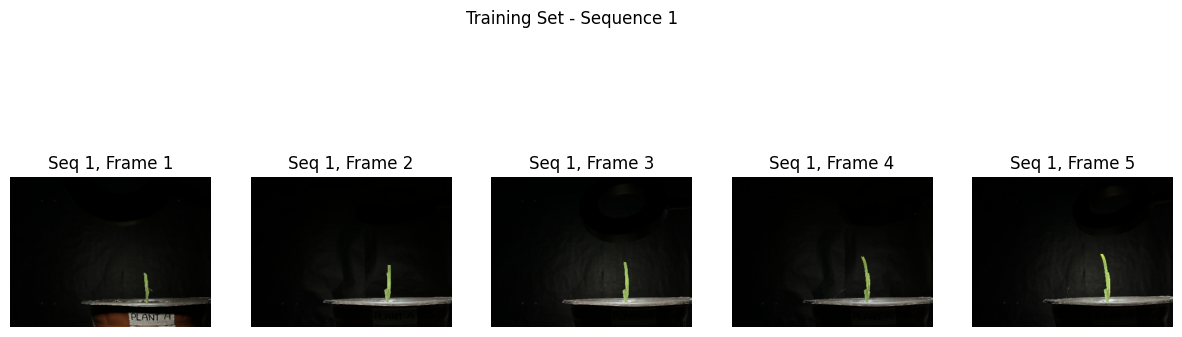

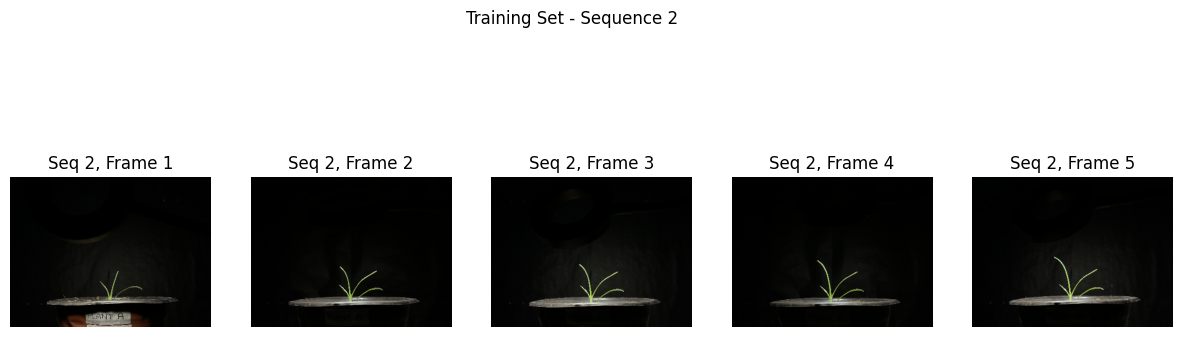

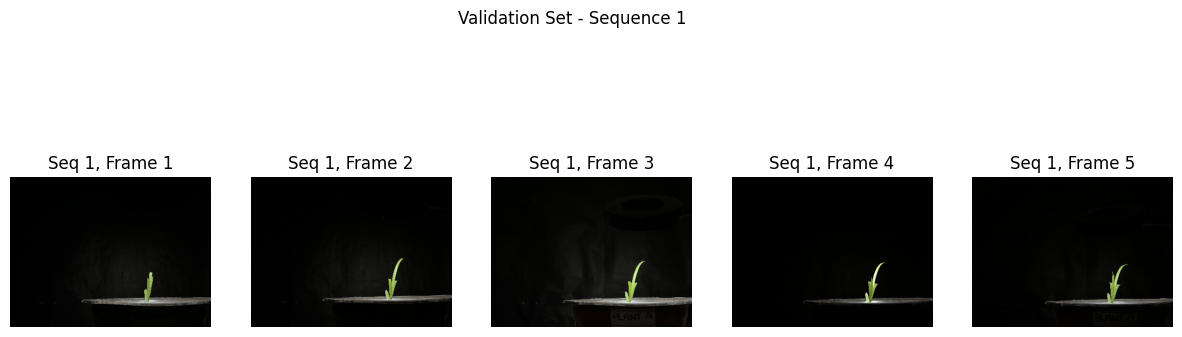

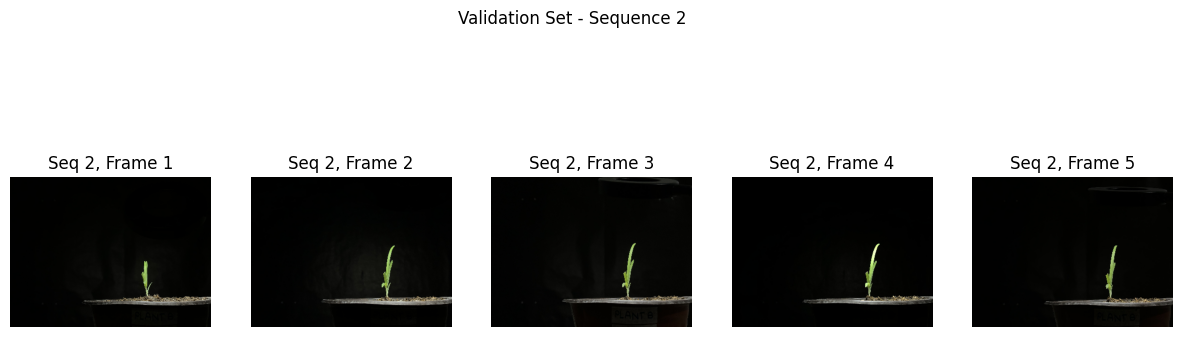

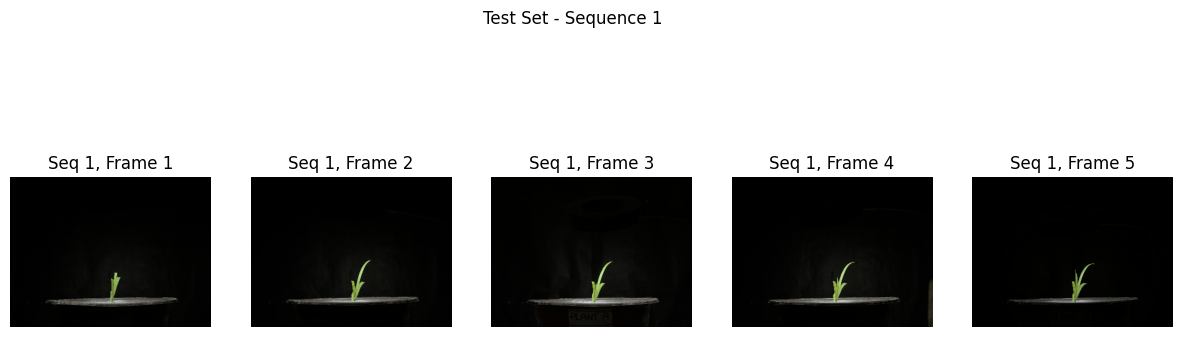

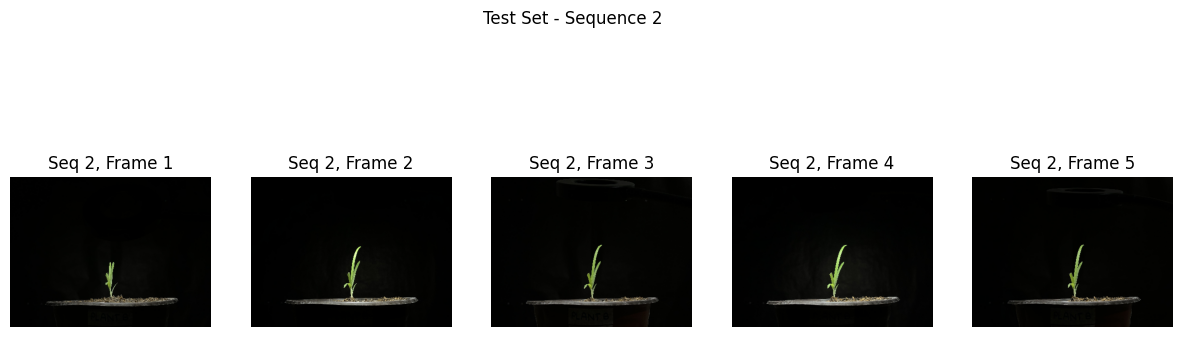

In [25]:
# Visualize sequences from the training set
visualize_sequences(train_sequences, 'Training')

# Visualize sequences from the validation set
visualize_sequences(val_sequences, 'Validation')

# Visualize sequences from the test set
visualize_sequences(test_sequences, 'Test')

# Segment plant object + Preprocess dataset

In [ ]:
train_dataset = train_dataset.map(process_sequence_tf, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(process_sequence_tf, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(process_sequence_tf, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Apply data augmentation only to the training set
train_dataset = train_dataset.map(lambda x: augment_sequence(x), num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_dataset = train_dataset.map(create_input_target, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(create_input_target, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# For the training dataset
train_dataset = (
    train_dataset
    .cache()
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

val_dataset = (
    val_dataset
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

test_dataset = (
    test_dataset
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

Verify shapes

In [ ]:
# Example of verifying shapes
for inputs, targets in train_dataset.take(1):
    print('Inputs shape:', inputs.shape)   # Expected: (BATCH_SIZE, sequence_length - 1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
    print('Targets shape:', targets.shape) # Expected: (BATCH_SIZE, sequence_length - 1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

# Develop model

## *Iteration X*

### Build model

### Visualize model

### Compile model

### Train model

### Plot results

## *Iteration 1*

### Build model

In [ ]:
model = models.Sequential([
    layers.Input(shape=(None, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)),
    layers.ConvLSTM2D(
        filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
    ),
    layers.BatchNormalization(),
    layers.ConvLSTM2D(
        filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
    ),
    layers.BatchNormalization(),
    layers.ConvLSTM2D(
        filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
    ),
    layers.BatchNormalization(),
    layers.ConvLSTM2D(
        filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
    ),
    layers.BatchNormalization(),
    layers.Conv3D(
        filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
    ),
])

### Visualize model

In [ ]:
model.summary()

### Compile model

In [ ]:
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER)

### Train model

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

### Plot results

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Visualize results

In [ ]:
# Select a sequence from the training set
example_sequence_paths = train_sequences[0]  # Adjust index as needed
example_sequence = preprocess_sequence(example_sequence_paths, MAX_SEQUENCE_LENGTH)

# Prepare inputs
example_input = example_sequence[:-1]  # Inputs
example_target = example_sequence[1:]  # Ground truth

# Expand dimensions to simulate batch size of 1
example_input = np.expand_dims(example_input, axis=0)  # Shape: (1, sequence_length, 40, 40, 1)

# Predict the sequence
predicted_sequence = model.predict(example_input)
predicted_sequence = predicted_sequence[0]  # Remove batch dimension

# Visualize the results
num_frames = 5  # Number of frames to display

plt.figure(figsize=(15, 6))

# Original frames
for i in range(num_frames):
    plt.subplot(2, num_frames, i + 1)
    plt.imshow(example_sequence[i])
    plt.title(f'Frame {i + 1} (Original)')
    plt.axis('off')

# Predicted frames
for i in range(num_frames):
    plt.subplot(2, num_frames, num_frames + i + 1)
    if i < 3:
        # Show original frames for the first 3 frames
        plt.imshow(example_sequence[i])
        plt.title(f'Frame {i + 1} (Original)')
    else:
        # Show predicted frames for subsequent frames
        plt.imshow(predicted_sequence[i])
        plt.title(f'Frame {i + 1} (Predicted)')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Test model